In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics._ranking import _binary_clf_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA

def roc_curve(y_true, y_score, pos_label=None, sample_weight=None,
              drop_intermediate=True):
    """Compute Receiver operating characteristic (ROC)

    Note: this implementation is restricted to the binary classification task.

    Read more in the :ref:`User Guide <roc_metrics>`.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        True binary labels in range {0, 1} or {-1, 1}.  If labels are not
        binary, pos_label should be explicitly given.

    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive
        class, confidence values, or non-thresholded measure of decisions
        (as returned by "decision_function" on some classifiers).

    pos_label : int or str, default=None
        Label considered as positive and others are considered negative.

    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.

    drop_intermediate : boolean, optional (default=True)
        Whether to drop some suboptimal thresholds which would not appear
        on a plotted ROC curve. This is useful in order to create lighter
        ROC curves.

        .. versionadded:: 0.17
           parameter *drop_intermediate*.

    Returns
    -------
    fpr : array, shape = [>2]
        Increasing false positive rates such that element i is the false
        positive rate of predictions with score >= thresholds[i].

    tpr : array, shape = [>2]
        Increasing true positive rates such that element i is the true
        positive rate of predictions with score >= thresholds[i].

    thresholds : array, shape = [n_thresholds]
        Decreasing thresholds on the decision function used to compute
        fpr and tpr. `thresholds[0]` represents no instances being predicted
        and is arbitrarily set to `max(y_score) + 1`.

    See also
    --------
    roc_auc_score : Compute the area under the ROC curve

    Notes
    -----
    Since the thresholds are sorted from low to high values, they
    are reversed upon returning them to ensure they correspond to both ``fpr``
    and ``tpr``, which are sorted in reversed order during their calculation.

    References
    ----------
    .. [1] `Wikipedia entry for the Receiver operating characteristic
            <https://en.wikipedia.org/wiki/Receiver_operating_characteristic>`_


    Examples
    --------
    >>> import numpy as np
    >>> from sklearn import metrics
    >>> y = np.array([1, 1, 2, 2])
    >>> scores = np.array([0.1, 0.4, 0.35, 0.8])
    >>> fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
    >>> fpr
    array([ 0. ,  0.5,  0.5,  1. ])
    >>> tpr
    array([ 0.5,  0.5,  1. ,  1. ])
    >>> thresholds
    array([ 0.8 ,  0.4 ,  0.35,  0.1 ])

    """
    fps, tps, thresholds = _binary_clf_curve(
        y_true, y_score, pos_label=pos_label, sample_weight=sample_weight)

    # Attempt to drop thresholds corresponding to points in between and
    # collinear with other points. These are always suboptimal and do not
    # appear on a plotted ROC curve (and thus do not affect the AUC).
    # Here np.diff(_, 2) is used as a "second derivative" to tell if there
    # is a corner at the point. Both fps and tps must be tested to handle
    # thresholds with multiple data points (which are combined in
    # _binary_clf_curve). This keeps all cases where the point should be kept,
    # but does not drop more complicated cases like fps = [1, 3, 7],
    # tps = [1, 2, 4]; there is no harm in keeping too many thresholds.
    if drop_intermediate and len(fps) > 2:
        optimal_idxs = np.where(np.r_[True,
                                      np.logical_or(np.diff(fps, 2),
                                                    np.diff(tps, 2)),
                                      True])[0]
        fps = fps[optimal_idxs]
        tps = tps[optimal_idxs]
        thresholds = thresholds[optimal_idxs]

    if tps.size == 0 or fps[0] != 0:
        # Add an extra threshold position if necessary
        tps = np.r_[0, tps]
        fps = np.r_[0, fps]
        thresholds = np.r_[thresholds[0] + 1, thresholds]

    if fps[-1] <= 0:
        warnings.warn("No negative samples in y_true, "
                      "false positive value should be meaningless",
                      UndefinedMetricWarning)
        fpr = np.repeat(np.nan, fps.shape)
    else:
        fpr = fps / fps[-1]

    if tps[-1] <= 0:
        warnings.warn("No positive samples in y_true, "
                      "true positive value should be meaningless",
                      UndefinedMetricWarning)
        tpr = np.repeat(np.nan, tps.shape)
    else:
        tpr = tps / tps[-1]

    return fpr, tpr, thresholds

# level for the radical indicators: application/docdb/inpadoc
level_list = ['docdb','inpadoc']
level = 0

# lists with control variables
controls = ['applt_cnt', 'invt_cnt','nr_bw_cites', 'nr_npl_cites', 'nr_claims', 'nr_ipc4', 'nr_ipc6'] 
time_dummies = list(range(1981,2002))
existing_exante = ['original_ipc4', 'original_ipc6', 'shane_ipc3', 'shane_ipc4', 'shane_ipc6']

# lists with radical indicators
nto_dummy = ['nto4', 'nto6']
nso_dummy = ['nso4', 'nso6']
nf_dummy = ['nf4', 'nf6']
nto_count = ['nto4_count', 'nto6_count']
nso_count= ['nso4_count', 'nso6_count']
nf_count = ['nf4_count', 'nf6_count']
nto_corr = ['nto4_corr', 'nto6_corr']
nso_corr = ['nso4_corr', 'nso6_corr']
nf_corr = ['nf4_corr', 'nf6_corr']
nto_all = nto_dummy + nto_count + nto_corr
nso_all = nso_dummy + nso_count + nso_corr
nf_all = nf_dummy + nf_count + nf_corr
new_rad = ['top_avg_md_sd3']

rad_dumm = nto_dummy + nso_dummy + nf_dummy #+ new_rad
rad_count = nto_count + nso_count + nf_count #+ new_rad
rad_corr = nto_corr + nso_corr + nf_corr #+new_rad
rad_all = nto_all + nso_all + nf_all #+ new_rad

scalable = controls + existing_exante + nto_count + nso_count + nf_count + new_rad

# Load the df with docdb-level features/target (sería mejor hacer una función que haga todo esto y llamarla con family type??)
df = pd.read_csv('01_biotech_val_data_docdb.csv')
df['patage'] = df['appy'] - df['appy'].min() # drop this, I do not use patage anymore
list_ipc4 = [x for x in df.columns if x[:6]=='ipc4__']
df = df.merge(pd.get_dummies(df['appy']), left_index=True,right_index=True)
X = df[list_ipc4 + controls + time_dummies + existing_exante + rad_all]
y = df['important'];

# Predicting breakthrough biotech patents with machine learning models

### 1. Introduction
<b> The importance of breakthroughs.</b> Early and accurate prediction of patents with high value and technological impact, often called *breakthrough patents*, has considerable strategic, commercial and financial importance for firms. On the one hand, R&D-performing firms that develop new technologies need accurate predictions of their R&D pipelines' value and potential. On the other hand, downstream firms that acquire or license technologies and patents from external partners need ever more accurate predictions about the potential of those patents. Moreover, because investing in the right technology can help firms build a competitive advantage and a solid market position, early prediction of technological breakthroughs is of strategic importance in nascent markets and sectors (e.g., biotechnology in the 1980s or carbon nanotubes in 2010s). Additionally, firms keep patents *alive* by paying hefty renewal fees, and accurate prediction of breakthroughs can help improve their patent portfolio strategies based on real evidence. However, patents vary greatly in terms of value and technological importance. In fact, the vast majority of patents are worthless while breakthroughs are few, infrequent and hence very difficult to predict. 

This notebook presents a supervised learning task. In it, I build predictive machine learning models for breakthrough patents and train/validate them using patent data from the early stage of the biotechnology sector---between 1986 and 2001.

<b> Approach, models and data.</b> In all models an instance is a biotech patent, a binary target indicates whether the patent has been classified as a biotech breakthrough and model features are patent-based indicators (i.e., indicators and metrics built using patent data). The baseline model is a logistic classifier which includes the typical features present in studies of technological breakthroughs (both the model and the features are the prevalent approach in these kind of studies, e.g., Arts et al. 20XX). I extend the baseline model in three consecutive steps:
1.  Adding to the model new patent-based features that characterize a patent's technological novelty. 
1.  Recalculating features using the INPADOC "patent family" correction. 
1.  Training a random forests classifier (RFC) on the family-corrected features. 

The first step is motivated by recent scientific literature showing that technological novelty is a powerful predictor of breakthroughs (e.g., Verhoeven et al. 2016). The second step is motivated by: a) scientific literature showing that meta-data from patent families (legally speaking, a group of patents linked by priority claims) can help increase target and feature accuracy (e.g., Harhoff et al. 2003, Bakker et al. 2015, Bakker 2017)<!---Harhoff, Scherer, and Vopel, 2003 -->; and b) the existence of different definitions and operationalizations of "patent family." Finally, the third step is motivated by the flexibility of RFCs and their potential for reducing overfitting. All models are trained using a dataset composed by 82,546 patents applied between 1986 and 2001, which amount to all the biotech patents granted by the US Patent and Trademark Office (USPTO) and applied during that period. 

<b> Results.</b> Less than 0.05% of patents in the dataset are breakthroughs. As expected, breakthroughs are extremely rare and the target vector is highly unbalanced. Hence, to measure models' predictive power I compare recall, precision and AUC scores, rather than accuracy. For the baseline model, the recall, precision and AUC scores are 0.17, 0.87 and 0.59, respectively. All other models outperform the baseline, to different degrees. The random forests model shows the largest gains, improving recall, precision and AUC with respect to the baseline by 298%, 15% and 55%, respectively.



### 2. Data, target and features
<b>Patent data and patent-based indicators.</b> Patent documents are a rich source of invention data and meta-data that can be used to build patent-based indicators (e.g., patent claims, technological principles and components, but also co-inventors, applicant firms, application date, prior art, etc.).  In a broad sense, there are two types of patent-based indicators: ex-ante and ex-post indicators. Ex-ante indicators are built with data available up to moment of the patent application (e.g., inventor names, citations made by the patent to prior art, etc.). By contrast, ex-post indicators use data which is generated and/or available only after the patent application (e.g., citations received by the patent after its publication by the patent office, commercial performance of the patented invention, licensing revenue, etc.).

Ex-post indicators, such as citations received, are strongly correlated with patent value and impact. However, such indicators can only be computed many years after the patent application, so, by definition, they cannot be used as early predictors of breakthroughs. In line with the goal of this notebook, models are trained using only ex-ante indicators.

<b>Data.</b> The dataset consists of all biotechnology patents (following the OECD 2006 definition) granted by the USPTO, and applied between 1985 and 2001 (n=82,546). All patent data was sourced from Patstat v2018-Autumn.

<b>Target.</b> Target labels are taken from Arts et al. (20XX), who identified the most important biotech inventions and mapped them to their respective patents. The target, *important*, equals 1 if the patent is an important biotech invention and 0 otherwise.

<b>Features.</b> Models use three types of features: control, *existing* ex-ante and *new* ex-ante features. The features of each type are:
-  Controls: counts of distinct IPC4 and IPC6 classes (i.e., 4- and 6-digit International Patent Classification classes), claims, backward citations, non-patent citations, inventors and applicants. Further controls are features for each IPC4 technology class and one-hot dummies for application years.
-  Existing ex-ante: Originality (Trajtenberg et al. 1997) computed at IPC4 and IPC6 levels; Radicalness (Shane 2001) computed at IPC3, IPC4 and IPC6 levels.
-  New ex-ante: <i>New technological origins</i> (NTO), <i>New functionality</i> (NF) and <i>New scientific origins</i> (NSO) (see Verhoeven et al. 2016 for definitions and details on how to construct these features). Each feature measures a different dimension of technological novelty and is calculated with different degrees of granularity, using either IPC4 or IPC6 classes. Each feature takes integer values, where a greater value represents a greater score in the respective dimension.

<b>Patent families.</b> There are different definitions of patent family, and this notebook uses two of them: DOCDB and INPADOC. The DOCDB definition is useful for finding 'equivalent' patents: this is the case when the same patent is filed at different patent offices (i.e., patents are linked to the same invention, but in different geographies). The INPADOC definition is useful for finding patents that cover (different parts of) the same invention. Hence, patents in an INPADOC family are not necessarily equivalent, but they are connected through similar claims on related subject matter. The baseline model uses the DOCDB definition and I later on use the INPADOC definition to improve model performance.
    
### 3. Exploring the dataset: Are patent-based indicators of novelty good predictors of breakthrough patents?

This notebook relies on the power of ex-ante indicators of technological novelty to predict breakthroughs, in a supervised learning task. A sensible step before plugging features in any model is to explore how they relate with the target through simple descriptive statistics. 

Figure 1 below shows the breakthrough rate in subsets of patents that have different scores of NTO4, NSO4 and NF4. Recall that breakthroughs represent 0.3% of the patents in the dataset and the features take integer values (where larger value equals larger novelty score). For simplicity, I've split each feature in three groups according to its score: 0, 1-3 and >=4. Figure 1 reveals a positive relationship between feature score and breakthrough rate. Breakthrough rates in the subsets with the lowest score are similar to the unconditional rate (~0.003) and increase as with score. Indeed, breakthrough rates in patents with a score equal or greater than 4 (the green column) are larger than the unconditional rate by several orders of magnitude: 0.089, 0.049 and 0.238. This implies that, for instance, 24% of patents scoring 4 or more in NF4 are breakthroughs.

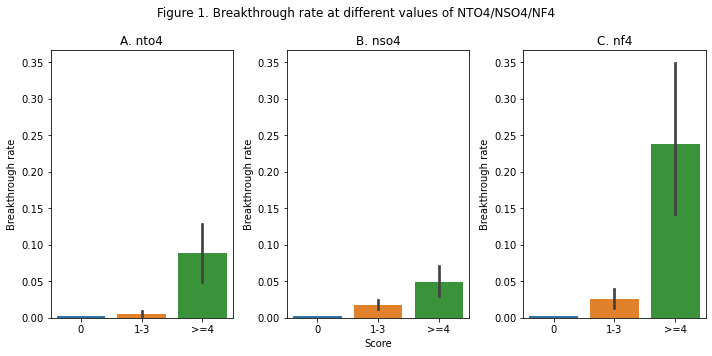

In [80]:
for i in ['nto4','nso4','nf4','nto6','nso6','nf6']:
    df.loc[df['{}_count'.format(i)]==0,'{}_count_cat'.format(i)] = '0'
    df.loc[df['{}_count'.format(i)]>0,'{}_count_cat'.format(i)] = '1-3'
    df.loc[df['{}_count'.format(i)]>3,'{}_count_cat'.format(i)] = '>=4'

rad_dummies = ['nto4_count_cat', 'nso4_count_cat', 'nf4_count_cat']
titles = ['A. nto4', 'B. nso4', 'C. nf4']
fig, axes = plt.subplots(1,3, sharey='row',figsize=(10,5))
for i in range(3):
    sns.barplot(data=df, x=rad_dummies[i], y='important', ax=axes[i])
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('Breakthrough rate')
    if i==1:
        axes[i].set_xlabel('Score')
    else:
        axes[i].set_xlabel('')
    axes[i].yaxis.set_tick_params(labelbottom=True)
fig.suptitle('Figure 1. Breakthrough rate at different values of NTO4/NSO4/NF4', y=0.98)
fig.subplots_adjust(top=0.8)
plt.tight_layout();

In [81]:
### Table with breakthrough rates
print('Table 1. Breakthrough rate for subsets with different scores of NTO4, NSO4 and NF4')
pd.options.display.float_format = '{:,.3f}'.format
pd.DataFrame(df[['nto4_count_cat','important']].rename(columns={'nto4_count_cat':'score','important':'nto4'}).groupby('score')['nto4'].mean()).merge(
df[['nso4_count_cat','important']].rename(columns={'nso4_count_cat':'score','important':'nso4'}).groupby('score')['nso4'].mean(),
left_on='score',right_index=True).merge(
df[['nf4_count_cat','important']].rename(columns={'nf4_count_cat':'score','important':'nf4'}).groupby('score')['nf4'].mean(),
left_on='score',right_index=True)

Table 1. Breakthrough rate for subsets with different scores of NTO4, NSO4 and NF4


,nto4,nso4,nf4
score,,,
0,0.003,0.002,0.003
1-3,0.006,0.018,0.026
>=4,0.089,0.049,0.238


The values of NTO4, NSO4 and NF4 are not mutually exclusive in a patent, so I explore next if scoring in multiple indicators at once is a good predictor of higher breakthrough rates. To do this I calculate a new feature, *Composite4*, which indicates in how many of these indicators the patent has a positive score (i.e., greater than zero). Hence, this feature takes integer values between 0 and 4.

I also calculated <i>Composite4 score</i> as the sum of NTO4, NSO4 and NF4. Figure 2 below shows the breakthrough rates for these new indicators and suggests that scoring in multiple features is a good predictor of breakthroughs. First, Panel A shows that patents with a positive score in NTO4, NSO4 and NF4 have a breakthrough probability equal to 12.5%. Second, Panel B shows that patents with a composite score equal or greater than 4 have a breakthrough probability of about 5%. Notably, the confidence intervals are significantly smaller than those in Figure 1.



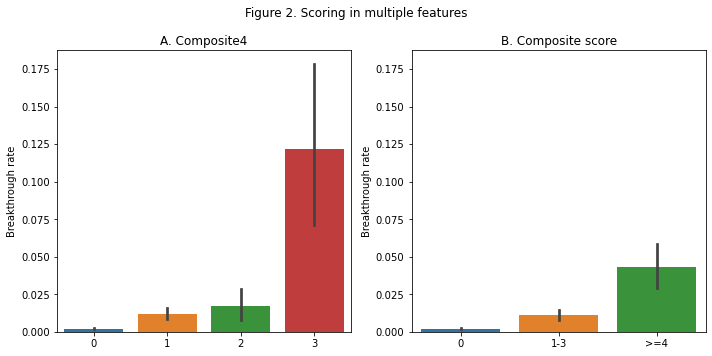

In [82]:
df['comp_dum4'] = df['nto4'] + df['nso4'] + df['nf4']
df['comp_dum4'] = df['nto4'] + df['nso4'] + df['nf4']
df.loc[df['nto4_count'] + df['nso4_count'] + df['nf4_count']==0,'comp_dum4_cat'] = '0'
df.loc[df['nto4_count'] + df['nso4_count'] + df['nf4_count']>0,'comp_dum4_cat'] = '1-3'
df.loc[df['nto4_count'] + df['nso4_count'] + df['nf4_count']>3,'comp_dum4_cat'] = '>=4'

fig, axes = plt.subplots(1,2, sharey='row', figsize=(10, 5))
sns.barplot(data=df, x='comp_dum4', y='important', ax=axes[0])
sns.barplot(data=df, x='comp_dum4_cat', y='important', ax=axes[1])
axes[0].set_title('A. Composite4')
axes[1].set_title('B. Composite score')
axes[1].yaxis.set_tick_params(labelbottom=True)
for i in [0,1]:
    axes[i].set_ylabel('Breakthrough rate')
    axes[i].set_xlabel('')
fig.suptitle('Figure 2. Scoring in multiple features', y=0.98)
fig.subplots_adjust(top=0.8)
plt.tight_layout();

### 4. Supervised learning (i): Logistic classifiers

I begin the (exploratory) supervised learning task by training logistic classifiers on the complete dataset. This allows to compare the overall performance of the baseline and extended models. In a later step I examine the predictive power of the model with the customary validation: a train/test split. 

<b>Preprocessing. </b> Training logistic classifiers requires preprocessing the dataset. Accordingly, non-categorical features were log-transformed and scaled with MinMaxScaler.

<b>Feature engineering. </b> The feature with patents' application years was one-hot encoded into a set of dummies. Each of the novelty features (NSO, NTO, etc) was used to create two additional features: a dummy (which equals one if the focal feature's value is greater than zero) and an IPC-corrected feature (which corrects for the number of IPC classes in a patent, taking into account that patents with more IPC classes are by default more likely to get higher novelty scores).

<b>Hyperparameter tuning. </b> It was performed as a grid search over potential values of lambda, the penalty and the scaler (but not reported here for parsimony). Results indicate the best models are obtained by setting lambda equal to 3, 'l2' as the penalty and MinMaxScaler to scale features.
    
<b>Model results. </b> Table 1 reports the models and their performance/quality indicators. All models include features for the IPC4 technology classes, control variables and existing ex-ante indicators. Model 1 is the baseline and hence does not include the novelty features nor the INPADOC correction. Overall, the performance of the model is rather poor, especially in terms of recall. Recall is 0.17, precision is 0.87 and average precision is 0.29. In other words, the model detects only 17% of the true breakthroughs with a precision of 87%.
    
Model 2 extends the baseline by including novelty features, while Model 3 includes both novelty features and the INPADOC correction. Both models increase predictive power relative to the baseline. Model 3 increases recall by 105%, precision by 5%, average precision by 88% and the AUC score by 15%. For further comparison, Figure 2 presents the estimated ROC curves and precision-recall curves for each model. Panel B confirms that the INPADOC family correction produces a sensible increase in average precision (the precision-recall curve moves to the right).    

Table 2. Results from logistic classifier models

                        Model 1 Model 2 Model 3
IPC4                        Yes     Yes     Yes
Controls                    Yes     Yes     Yes
Existing ex-ante            Yes     Yes     Yes
Novelty                      No     Yes     Yes
Inpadoc fam. correction      No      No     Yes
Penalty                      l2      l2      l2
Lambda                        3       3       3
Recall (cutoff=0.5)       0.174    0.22   0.357
Precision (cutoff=0.5)    0.872   0.945   0.921
Accuracy                  0.998   0.998   0.995
Average precision         0.297   0.361   0.561
AUC                       0.587    0.61   0.678


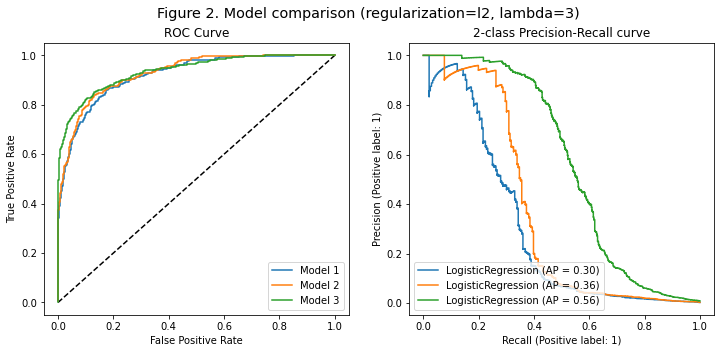

In [83]:
## Logistic models
def model(rad_levels, vect_features, feature_names, cutoff=.5, scaler=None, plot=False, label='important', penalty='l2', condensed=False, solver='lbfgs',lambda_=1, l1_ratio=None):
    global plots, outc
    
    if all(item in ['appln','docdb','inpadoc'] for item in rad_levels)==False:
        print("""Unrecognized value for rad_levels. Valid values are 'appln','docdb' and 'inpadoc'""")
        return    
   
    if 'StandardScaler' not in ['StandardScaler','MinMaxScaler']:
        print("""Unrecognized value for scaler. Valid values are None, 'MinMaxScaler' and 'StandardScaler'""")
        return

    outcomes = []
    
    scalers = {'MinMaxScaler':MinMaxScaler(),'StandardScaler':StandardScaler()}
    
    m=0
    
    if plot==True:
        models  = []
        
        fig, axs = plt.subplots(1, 2,figsize=(12,5))
        st = fig.suptitle("Figure 2. Model comparison (regularization={}, lambda={})".format(penalty,lambda_), fontsize="x-large")
        #st.set_y(0.90)
        
        axs[0].plot([0, 1], [0, 1], 'k--')
        axs[0].set_xlabel('False Positive Rate')
        axs[0].set_ylabel('True Positive Rate')
        axs[0].set_title('ROC Curve')
        
        axs[1].set_title('2-class Precision-Recall curve')
        
    for j in rad_levels:

        df = pd.read_csv('01_biotech_val_data_{}.csv'.format(j))
        #df = pd.concat([df[df['important']==1], df[df['important']==0].sample(frac=.30, random_state=10)])
        y = df[label]
        df['patage'] = df['appy'] - df['appy'].min()
        list_ipc4 = [x for x in df.columns if x[:6]=='ipc4__']
        df = df.merge(pd.get_dummies(df['appy']), left_index=True,right_index=True)
        
        transformer = FunctionTransformer(np.log1p, validate=True)
        df[scalable] = transformer.transform(df[scalable])
        
        if scaler in ['MinMaxScaler','StandardScaler']:
            #print('Escalando con {}'.format(scaler))
            scaled = scalers[scaler].fit(df[scalable])
            df[scalable] = scaled.transform(df[scalable])
        
        for vect in vect_features:
            
            if (condensed==True) & (vect==[1,1,1,0]) & (j=='inpadoc'):
                continue
            
            logreg = LogisticRegression(max_iter=1000, penalty=penalty, solver=solver, C=lambda_, l1_ratio=l1_ratio)        
            
            lis = []
            
            model_desc = vect
            model_desc = model_desc + ['No' if j=='docdb' else 'Yes'.format(j) for j in [j]]

            for i in range(len(vect)):
                if vect[i]:
                    lis = lis + list_[i]
                    
            X = df[lis]
            logreg.fit(X, y)
            
            y_pred = np.array([1 if x>=cutoff else 0 for x in logreg.predict_proba(X)[:,1]])
            
            y_score = logreg.decision_function(X)
            average_precision = average_precision_score(y, y_score)            
            false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(y, y_pred)
            roc_auc_test = auc(false_positive_rate_test, true_positive_rate_test)
            
            model_desc = model_desc + [penalty,lambda_, recall_score(y,y_pred), precision_score(y, y_pred),   accuracy_score(y, y_pred),  average_precision, roc_auc_test]
        
            outcomes.append(model_desc)            
            
            if plot==True:                                
                y_pred_prob = logreg.predict_proba(X)[:,1]
                fpr, tpr, thresholds = roc_curve(y, y_pred_prob)        
                axs[0].plot(fpr, tpr, label='Model {}'.format(m+1))
                axs[0].legend()
                plots.append([fpr,tpr,thresholds])                

                plot_precision_recall_curve(logreg,X,y, ax=axs[1])        
                
            m+=1
            
    outcomes_df = pd.DataFrame(outcomes).T
    outcomes_df.columns = ['Model {}'.format(x+1) for x in range(outcomes_df.shape[1])]
    outcomes_df.iloc[0:len(feature_names),:] = outcomes_df.iloc[0:len(feature_names),:].replace({0:'No',1:'Yes'})
    outcomes_df.index =  feature_names + ['Inpadoc fam. correction'] + ['Penalty','Lambda','Recall (cutoff={})'.format(cutoff),'Precision (cutoff={})'.format(cutoff),'Accuracy','Average precision', 'AUC']    
        
    return outcomes_df

list_ = [list_ipc4, controls+time_dummies, existing_exante, rad_all]
feature_names = ['IPC4','Controls','Existing ex-ante','Novelty']
vect_features = [[1,1,1,0],
                 [1,1,1,1]]

plots = []
outc = []
for scaler_ in ['MinMaxScaler']:
    model_out = model(['docdb','inpadoc'], vect_features, feature_names, scaler=scaler_, plot=True, condensed=True, penalty='l2', solver='liblinear', lambda_=3) 
    outc.append(model_out)

print('Table 2. Results from logistic classifier models\n')
print(outc[0]);


<b> Validating Model 3 with a train/test split. </b> After comparing the baseline and extended models, I perform a 70/30 train/test validation test to evaluate the predictive power of Model 3. To avoid data leakage, the scaler is trained on the train set and used to transform the test set afterwards. Table 3 and Figure 3 show the outcomes of the validation step. Results are in line with those shown above and do not raise concerns of over- or underfitting. 

Because the results of this validation test may depend on the way data is split into train and test sets, as a robustness check I performed a 4-fold cross validation on each of the quality indicators. Results are similar to those reported above (available upon request). Additionally, I ran the train/test validation step on the full dataset 100 times using random values for random_state (the parameter that controls how the data is split), calculating performance indicators each time and averaging them out. Results are similar to those reported here (available upon request).

Table 3. Train/test split validation for Model 3

                        Train  Test
IPC4                      Yes   Yes
Controls                  Yes   Yes
Existing ex-ante          Yes   Yes
Novelty                   Yes   Yes
INPADOC fam. correction   Yes   Yes
Recall                  0.312 0.347
Precision                0.89 0.884
Accuracy                0.995 0.995
Avg precision            0.52 0.545
AUC                     0.656 0.673


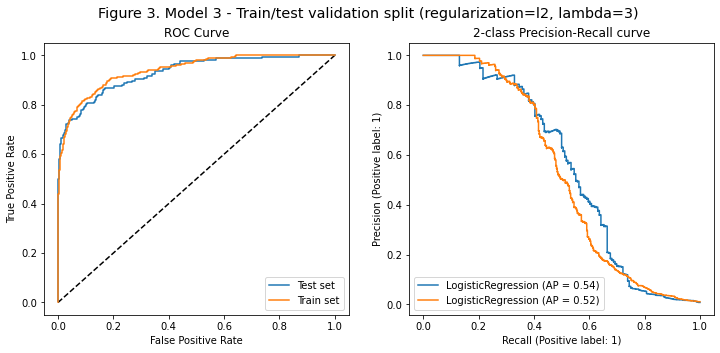

In [84]:
# con validation set
def train_test(j='inpadoc', penalty='l1', solver='liblinear', lambda_=1, random_state=12, scaler=None):
    
    if scaler not in [None,'MinMaxScaler','StandardScaler']:
        return print('Valor de scaler incorrecto. Scalers posibles son None, MinMaxScaler o StandarScaler')
    
    df = pd.read_csv('01_biotech_val_data_{}.csv'.format(j))    
    df['patage'] = df['appy'] - df['appy'].min()
    list_ipc4 = [x for x in df.columns if x[:6]=='ipc4__']
    df = df.merge(pd.get_dummies(df['appy']), left_index=True,right_index=True)    
    transformer = FunctionTransformer(np.log1p, validate=True)
    df[scalable] = transformer.transform(df[scalable])    
    X = df[list_ipc4 + controls + time_dummies + existing_exante + rad_all]
    y = df['important']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=random_state)      
    
    if scaler in ['MinMaxScaler','StandardScaler']:
        scalers = {'MinMaxScaler':MinMaxScaler(),'StandardScaler':StandardScaler()}
        #print('Escalando con {}'.format(scaler))
        X_train = scalers[scaler].fit_transform(X_train)
        X_test = scalers[scaler].transform(X_test)
    
    logreg = LogisticRegression(max_iter=1000, penalty=penalty, solver='liblinear', C=lambda_)        
    logreg.fit(X_train, y_train)
    
    y_test_pred = logreg.predict(X_test)
    y_train_pred = logreg.predict(X_train)
    y_test_score = logreg.decision_function(X_test)
    average_precision_test = average_precision_score(y_test, y_test_score)            
    y_train_score = logreg.decision_function(X_train)
    average_precision_train = average_precision_score(y_train, y_train_score)            
    
    false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(y_test, y_test_pred)
    roc_auc_test = auc(false_positive_rate_test, true_positive_rate_test)
    false_positive_rate_train, true_positive_rate_train, thresholds_train = roc_curve(y_train, y_train_pred)
    roc_auc_train = auc(false_positive_rate_train, true_positive_rate_train)    
    
    res = [['Yes','Yes']]*5
    res.append([round(recall_score(y_train,y_train_pred),3),round(recall_score(y_test,y_test_pred),3)])
    res.append([round(precision_score(y_train, y_train_pred),3), round(precision_score(y_test, y_test_pred),3)])
    res.append([round(accuracy_score(y_train, y_train_pred),3), round(accuracy_score(y_test, y_test_pred),3)])
    res.append([round(average_precision_train,3), round(average_precision_test,3)])
    res.append([round(roc_auc_train,3),round(roc_auc_test,3)])
    res = pd.DataFrame.from_records(res,columns=['Train','Test'],
                                    index=['IPC4', 'Controls','Existing ex-ante','Novelty','INPADOC fam. correction',
                                           'Recall','Precision','Accuracy','Avg precision','AUC'])
    
    #print('Confusion matrix','\n',confusion_matrix(y_test, y_test_pred))
    #print(classification_report(y_test, y_test_pred))
    
    m=0
    y_pred_prob = logreg.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)        
    fig, axs = plt.subplots(1, 2,figsize=(12,5))
    st = fig.suptitle("Figure 3. Model 3 - Train/test validation split (regularization={}, lambda={})".format(penalty,lambda_), fontsize="x-large")
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve')
    axs[0].plot(fpr, tpr, label='Test set')
    plot_precision_recall_curve(logreg,X_test,y_test, ax=axs[1])        
    axs[1].set_title('2-class Precision-Recall curve')
    
    m=1
    y_pred_prob = logreg.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)        
    axs[0].plot(fpr, tpr, label='Train set')
    plot_precision_recall_curve(logreg,X_train,y_train, ax=axs[1])
    axs[0].legend()      
    
    print('Table 3. Train/test split validation for Model 3\n')
    print(res)
    #return res

train_test(lambda_= 3, random_state=150, penalty='l2',scaler='MinMaxScaler',j='inpadoc') ;


### 5. Supervised learning (ii): Random forests classifier

In the final step, I reestimate Model 3 using a random forests classifier. RFC are ensemble models which train several sub-models (namely classification trees) using subsets of features and combine them using a voting rule to predict a target. The advantage of RFC over logistic classifiers is that training several models the overall structure becomes quite resilient to overfitting. As before, I performed a 70/30 train/test split as validation, an present the quality indicators in Table 4. 
In the test set, recall has risen to 0.69 and precision is equal to 1. This implies that the RFC is able to detect almost 70% of the true breakthroughs with full precision. Moreover, average precision and AUC have also increased significantly, to 0.87 and 0.85, respectively. 

Table 4. RFC - Quality indicators
 
                         Train  Test
IPC4                      Yes   Yes
Controls                  Yes   Yes
Existing ex-ante          Yes   Yes
Novelty                   Yes   Yes
INPADOC fam. correction   Yes   Yes
Recall                  0.966 0.693
Precision                 1.0   1.0
Accuracy                  1.0 0.998
Avg precision             1.0 0.872
AUC                     0.983 0.847


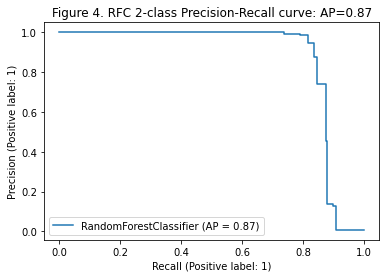

In [85]:
#### Random forest
j='inpadoc'
df = pd.read_csv('01_biotech_val_data_{}.csv'.format(j))
df['patage'] = df['appy'] - df['appy'].min()
list_ipc4 = [x for x in df.columns if x[:6]=='ipc4__']
df = df.merge(pd.get_dummies(df['appy']), left_index=True,right_index=True)

X = df[list_ipc4 + controls + time_dummies + existing_exante + rad_all]
y = df['important']

random_state=20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=random_state)      

scaler='MinMaxScaler'
scalers = {'MinMaxScaler':MinMaxScaler(),'StandardScaler':StandardScaler()}

rf = RandomForestClassifier(n_estimators=20, random_state=random_state, max_depth=25, max_features=30, min_samples_leaf=1, criterion='entropy')
rf.fit(X_train,y_train)

rf.score(X_train,y_train)
rf.score(X_test,y_test)

y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)
rmse_test = MSE(y_test,y_test_pred)**(1/2)
rmse_train = MSE(y_train,y_train_pred)**(1/2)
#print(rmse_train,rmse_test)

y_score = rf.predict_proba(X_test)[:,1]
average_precision_test = average_precision_score(y_test, y_score)
y_score_train = rf.predict_proba(X_train)[:,1]
average_precision_train = average_precision_score(y_train, y_score_train)

false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(false_positive_rate_test, true_positive_rate_test)
false_positive_rate_train, true_positive_rate_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(false_positive_rate_train, true_positive_rate_train)

res = [['Yes','Yes']]*5
res.append([round(recall_score(y_train,y_train_pred),3),round(recall_score(y_test,y_test_pred),3)])
res.append([round(precision_score(y_train, y_train_pred),3), round(precision_score(y_test, y_test_pred),3)])
res.append([round(accuracy_score(y_train, y_train_pred),3), round(accuracy_score(y_test, y_test_pred),3)])
res.append([round(average_precision_train,3), round(average_precision_test,3)])
res.append([round(roc_auc_train,3),round(roc_auc_test,3)])
res = pd.DataFrame.from_records(res,columns=['Train','Test'],
                                index=['IPC4', 'Controls','Existing ex-ante','Novelty','INPADOC fam. correction',
                                       'Recall','Precision','Accuracy','Avg precision','AUC'])

#print('Table 4. RFC - confusion matrix\n','\n',confusion_matrix(y_test, y_test_pred))
print('Table 4. RFC - Quality indicators\n','\n', res)

disp = plot_precision_recall_curve(rf, X_test, y_test)
disp.ax_.set_title('Figure 4. RFC 2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_test));


<b>Feature importance. </b> I extracted the most important features from the RFC model trained on the train data and plot them in Figure 5, by decreasing order of importance. Among the top 10 features by importance, 8 are ex-ante novelty indicators, which confirms their contribution to the prediction of breakthroughs. The most important feature is NTO4, with a score of 0.96. This is 4.57 times the score of the most important existing ex-ante feature (shane_ipc6, with a score of 0.21).

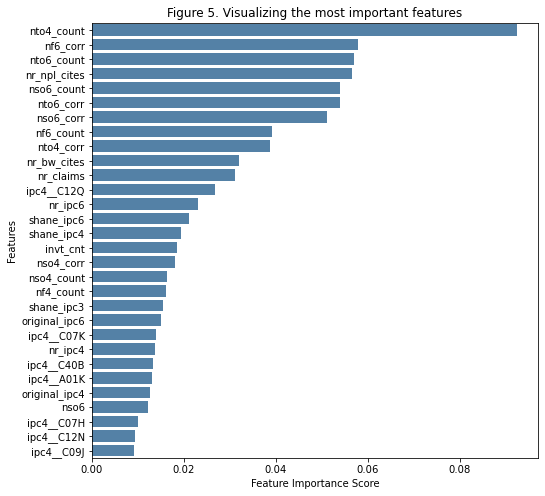

<Figure size 432x288 with 0 Axes>

In [86]:
# most important features
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp2 = feature_imp[:30]
plt.figure(figsize=(8,8));
sns.barplot(x=feature_imp2, y=feature_imp2.index, color='steelblue');
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Figure 5. Visualizing the most important features");
#plt.legend()
plt.show();
plt.tight_layout();